In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import mplhep as hep
import os

In [2]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-numpy/1.24.3-6c4922f4e317e74c4b82416c41722d10/lib/python3.9/site

In [3]:
# File paths for signal and background root files
signal_file_path = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/photons_0PU_bc_stc_hadd.root"
bg_file_path = "/grid_mnt/data__data.polcms/cms/debnath/CMSSW_14_0_0_pre1/src/neutrino_bg.h5"

# Open the root files (without 'with' to keep files open)
signal_file = uproot.open(signal_file_path)

# Open the HDF5 file for background (using pandas)
bg_file = pd.read_hdf(bg_file_path)  # Background data (already filtered)

# Folder names where the trees are stored (for ROOT file)
signal_folder = "FloatingpointMixedbcstcrealsig4DummyHistomaxxydr015GenmatchGenclustersntuple"
bg_folder = "l1tHGCalTriggerNtuplizer"  # This won't be used since we already have the background data in the form of a DataFrame

# Tree name to access within each file
tree_name = "HGCalTriggerNtuple"

# Build paths to the trees for ROOT file
signal_tree_path = f"{signal_folder}/{tree_name}"

# Access the signal tree in ROOT (uproot)
signal_tree = signal_file[signal_tree_path]

In [4]:
# Function to load and filter the signal tree data (for ROOT file)
def load_and_filter_signal_tree(tree, filter_pt, eta_range=(1.6, 2.8), cl_pt_threshold=5):
    df = ak.to_dataframe(tree.arrays(
        library="ak",
        filter_name=["gen_n", "gen_eta", "gen_phi", "gen_pt", 
                     "genpart_exeta", "genpart_exphi", "*cl3d*", "event"]
    ))
    df_filtered = df[(df['gen_pt'] > filter_pt) & 
                     (df['gen_eta'] > eta_range[0]) & 
                     (df['gen_eta'] < eta_range[1]) &
                     (df['cl3d_eta'] > eta_range[0]) & 
                     (df['cl3d_eta'] < eta_range[1]) &
                     (df['cl3d_pt'] > cl_pt_threshold)]
    return df_filtered

In [5]:
# Apply the filter to the signal data (only signal data needs filtering)
signal_df_filtered = load_and_filter_signal_tree(signal_tree, filter_pt=20)

# Since the background data is already filtered, no additional filtering is needed for it.
bg_df_filtered = bg_file  # Assuming the background DataFrame is already filtered

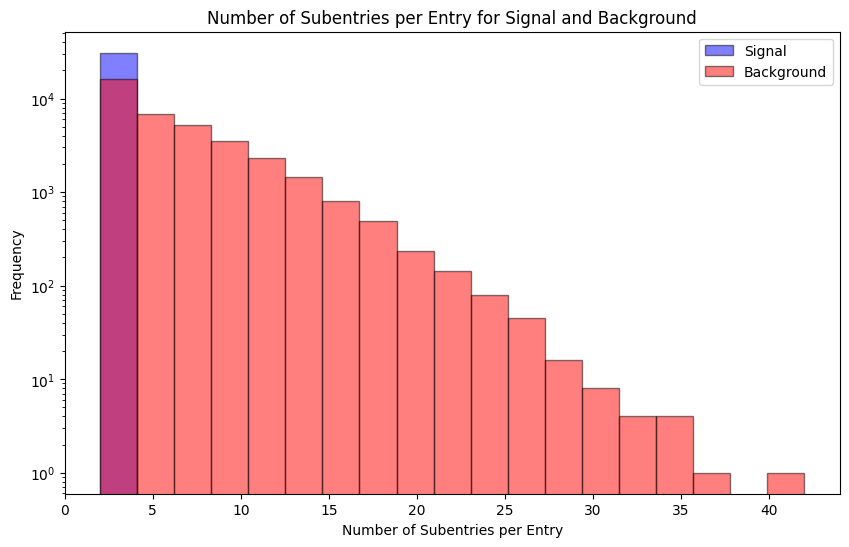

In [6]:
def count_subentries(df, entry_column="event", subentry_column="gen_n"):
    # Count the number of subentries (e.g., gen_n) for each entry (e.g., event)
    subentry_counts = df.groupby(entry_column)[subentry_column].count()
    return subentry_counts

# Count subentries for signal and background
signal_subentries = count_subentries(signal_df_filtered)
bg_subentries = count_subentries(bg_df_filtered)

# Create histograms for signal and background
plt.figure(figsize=(10, 6))

num_bins = 20
bins = np.linspace(min(min(signal_subentries), min(bg_subentries)), 
                  max(max(signal_subentries), max(bg_subentries)), 
                  num_bins)
# Plot the histograms
plt.hist(signal_subentries, bins=bins, alpha=0.5, label="Signal", color="blue", edgecolor="black")
plt.hist(bg_subentries, bins=bins, alpha=0.5, label="Background", color="red", edgecolor="black")

# Labels and title
plt.xlabel('Number of Subentries per Entry')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Number of Subentries per Entry for Signal and Background')
plt.legend()

# Show the plot
plt.show()

In [32]:
bg_df_filtered

event  gen_n   gen_eta   gen_phi    gen_pt   
entry subentry subsubentry                                                
2     185      0                 1    265  2.537290 -1.618968  0.283967  \
               1                 1    265  2.537290 -1.618968  0.283967   
      186      0                 1    265  2.084512  1.188023  0.276137   
               1                 1    265  2.084512  1.188023  0.276137   
4     165      0                 5    870  1.972438  0.599111  0.557168   
...                            ...    ...       ...       ...       ...   
639   151      1            157360   1525  2.478717  3.012680  1.415089   
      170      0            157360   1525  2.658884 -1.582477  0.947807   
               1            157360   1525  2.658884 -1.582477  0.947807   
      171      0            157360   1525  2.272959  0.521318  1.215321   
               1            157360   1525  2.272959  0.521318  1.215321   

                            genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry subentry subsubentry                                                     
2     185      0                 2.360581       3.606930     263  3021878292  \
               1                 2.360581       3.606930     263  3021878292   
      186      0                 2.044915       2.751452     263  3020194113   
               1                 2.044915       2.751452     263  3020194113   
4     165      0                 2.402080      -1.261151     220  2987675971   
...                                   ...            ...     ...         ...   
639   151      1                 2.676631      -3.790552     201  2988728597   
      170      0                 2.744529      -2.711406     201  2990432820   
               1                 2.744529      -2.711406     201  2990432820   
      171      0                -2.814030      -2.523114     201  3029246019   
               1                -2.814030      -2.523114     201  3029246019   

                              cl3d_pt  ...  cl3d_eot  cl3d_ebm0  cl3d_ebm1   
entry subentry subsubentry             ...                                   
2     185      0            11.269743  ...  0.792995       8190       3584  \
               1            11.269743  ...  0.792995       8190       3584   
      186      0             5.227857  ...  0.636611       8146          0   
               1             5.227857  ...  0.636611       8146          0   
4     165      0             6.974566  ...  0.893064       8153       1024   
...                               ...  ...       ...        ...        ...   
639   151      1             6.739515  ...  0.805972       8152       1280   
      170      0             6.332750  ...  0.944155       6120         32   
               1             6.332750  ...  0.944155       6120         32   
      171      0             7.898612  ...  0.579390       8083          0   
               1             7.898612  ...  0.579390       8083          0   

                            cl3d_hbm  cl3d_ntc67  cl3d_ntc90  cl3d_bdteg   
entry subentry subsubentry                                                 
2     185      0             1163264   25.459948   51.839870   -0.998781  \
               1             1163264   25.459948   51.839870   -0.998781   
      186      0             1314816   13.349099   28.507038   -0.998929   
               1             1314816   13.349099   28.507038   -0.998929   
4     165      0             3145752   11.318436   25.726927   -0.998929   
...                              ...         ...         ...         ...   
639   151      1             1769472   22.042114   40.081432   -0.998929   
      170      0              524288    2.091484    6.969759   -0.993153   
               1              524288    2.091484    6.969759   -0.993153   
      171      0             2359296    5.415942   19.777533   -0.998641   
               1             2359296    5.415942   19.777533   -0.998641   

        

In [33]:
signal_df_filtered

event  gen_n   gen_eta   gen_phi     gen_pt   
entry  subentry subsubentry                                                 
14     1        0              4680      2  1.917820 -1.477744  94.053398  \
                1              4680      2  1.917820 -1.477744  94.053398   
32     1        0              4673      2  2.384520  2.920790  92.494370   
                1              4673      2  2.384520  2.920790  92.494370   
37     1        0              4704      2  2.319600 -0.470938  40.315086   
...                             ...    ...       ...       ...        ...   
199996 1        1            113021      2  2.371188 -0.263157  83.995270   
199997 1        0            113033      2  2.563171 -2.477782  79.166039   
                1            113033      2  2.563171 -2.477782  79.166039   
199999 1        0            113034      2  2.788458 -0.375976  94.751396   
                1            113034      2  2.788458 -0.375976  94.751396   

                             genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry  subentry subsubentry                                                     
14     1        0                -1.477757       1.916971       2  2996761669  \
                1                -1.477757       1.916971       2  2996761669   
32     1        0                 2.920803       2.378510       2  2989237283   
                1                 2.920803       2.378510       2  2989237283   
37     1        0                -0.470946       2.337719       2  2989905154   
...                                    ...            ...     ...         ...   
199996 1        1                -0.263162       2.357926       2  2988848195   
199997 1        0                -2.477798       2.571761       2  2988851457   
                1                -2.477798       2.571761       2  2988851457   
199999 1        0                -0.376017       2.783430       2  2989372195   
                1                -0.376017       2.783430       2  2989372195   

                               cl3d_pt  ...  cl3d_eot  cl3d_ebm0  cl3d_ebm1   
entry  subentry subsubentry             ...                                   
14     1        0            86.336327  ...  0.998368      16383       8184  \
                1            86.336327  ...  0.998368      16383       8184   
32     1        0            85.325951  ...  1.000000      16383       4088   
                1            85.325951  ...  1.000000      16383       4088   
37     1        0            34.215042  ...  1.000000      16383       2032   
...                                ...  ...       ...        ...        ...   
199996 1        1            76.130898  ...  0.993184      16383       4092   
199997 1        0            73.411713  ...  1.000000      16383       8176   
                1            73.411713  ...  1.000000      16383       8176   
199999 1        0            87.961372  ...  0.998474      16383       4092   
                1            87.961372  ...  0.998474      16383       4092   

                             cl3d_hbm  cl3d_ntc67  cl3d_ntc90  cl3d_bdteg   
entry  subentry subsubentry                                                 
14     1        0             8388607    8.594174   28.036911    0.998573  \
                1             8388607    8.594174   28.036911    0.998573   
32     1        0             8388607    9.826604   27.081308    0.998573   
                1             8388607    9.826604   27.081308    0.998573   
37     1        0             8388607    8.204144   25.379555    0.986959   
...                               ...         ...         ...         ...   
199996 1        1             8388607   11.520021   26.761082    0.998573   
199997 1        0             8388607    8.931447   34.923149    0.998573   
                1             8388607    8.931447   34.923149    0.998573   
199999 1        0             8388607    9.559611   27.556578    0.998067   
                1     

In [49]:
def plot_histograms(df_signal, df_bg, variables, num_bins=40, int_num_bins=10, cl3d_pt_range=(20, 30), figsize=(8,4)):
    # Filter the signal and background DataFrames for cl3d_pt within the specified range
    df_signal_filtered = df_signal[(df_signal['cl3d_pt'] >= cl3d_pt_range[0]) & (df_signal['cl3d_pt'] <= cl3d_pt_range[1])]
    df_bg_filtered = df_bg[(df_bg['cl3d_pt'] >= cl3d_pt_range[0]) & (df_bg['cl3d_pt'] <= cl3d_pt_range[1])]

    for var in variables:
        plt.figure(figsize=figsize)
        
        # Check if the column contains integer values
        if df_signal_filtered[var].dtype in ['int64', 'int32']:
            # For integer columns, reduce the number of bins
            min_value = min(df_signal_filtered[var].min(), df_bg_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg_filtered[var].max())
            
            # Create bin edges for integer columns with reduced bins
            bin_edges = np.arange(min_value - 0.5, max_value + 1.5, (max_value - min_value) / int_num_bins)
            
        else:
            # For non-integer columns, use a normal binning strategy
            min_value = min(df_signal_filtered[var].min(), df_bg_filtered[var].min())
            max_value = max(df_signal_filtered[var].max(), df_bg_filtered[var].max())
            bin_width = (max_value - min_value) / num_bins
            
            # Adjust bin edges to center the bins around the data values
            bin_edges = np.arange(min_value - bin_width / 2, max_value + bin_width / 2, bin_width)

        # Plot the signal and background histograms with normalized distributions
        plt.hist(df_signal_filtered[var], bins=bin_edges, color='b', alpha=0.5, label='Signal', edgecolor='black', density=True)
        plt.hist(df_bg_filtered[var], bins=bin_edges, color='r', alpha=0.5, label='Background', edgecolor='black', density=True)
        
        # Set the plot title, labels, and log scale for y-axis
        plt.title(f"{var} Histogram (cl3d_pt between {cl3d_pt_range[0]} and {cl3d_pt_range[1]} GeV)")
        plt.xlabel(var)
        plt.ylabel('Normalized Frequency')
        plt.legend()
        
        # Adjust layout to prevent clipping
        plt.tight_layout()

        # Save the plot as a PNG file
        filename = f"{var}_histogram_log_cl3d_pt_{cl3d_pt_range[0]}_{cl3d_pt_range[1]}.png"
        plt.savefig(filename, dpi=300)
        print(f"Saved: {filename}")
        
        # Show the plot
        plt.show()
        
        # Close the plot to free memory
        plt.close()

In [35]:
# Define delta_r calculation function
def delta_r(eta1, phi1, eta2, phi2):
    delta_eta = eta1 - eta2
    delta_phi = np.abs(phi1 - phi2)
    delta_phi = np.where(delta_phi > np.pi, 2 * np.pi - delta_phi, delta_phi)  # Adjust phi to be within [-pi, pi]
    return np.sqrt(delta_eta**2 + delta_phi**2)


In [36]:
def filter_by_delta_r(df, delta_r_threshold=0.05):
    # Calculate delta R
    df['delta_r'] = delta_r(df['cl3d_eta'], df['cl3d_phi'], df['genpart_exeta'], df['genpart_exphi'])
    df_filtered = df[df['delta_r'] < delta_r_threshold]
    return df_filtered

In [37]:
df_signal_final_filtered = filter_by_delta_r(signal_df_filtered, delta_r_threshold=0.05)

In [38]:
df_signal_final_filtered

event  gen_n   gen_eta   gen_phi     gen_pt   
entry  subentry subsubentry                                                 
14     1        0              4680      2  1.917820 -1.477744  94.053398  \
                1              4680      2  1.917820 -1.477744  94.053398   
32     1        0              4673      2  2.384520  2.920790  92.494370   
                1              4673      2  2.384520  2.920790  92.494370   
37     1        0              4704      2  2.319600 -0.470938  40.315086   
...                             ...    ...       ...       ...        ...   
199996 1        1            113021      2  2.371188 -0.263157  83.995270   
199997 1        0            113033      2  2.563171 -2.477782  79.166039   
                1            113033      2  2.563171 -2.477782  79.166039   
199999 1        0            113034      2  2.788458 -0.375976  94.751396   
                1            113034      2  2.788458 -0.375976  94.751396   

                             genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry  subentry subsubentry                                                     
14     1        0                -1.477757       1.916971       2  2996761669  \
                1                -1.477757       1.916971       2  2996761669   
32     1        0                 2.920803       2.378510       2  2989237283   
                1                 2.920803       2.378510       2  2989237283   
37     1        0                -0.470946       2.337719       2  2989905154   
...                                    ...            ...     ...         ...   
199996 1        1                -0.263162       2.357926       2  2988848195   
199997 1        0                -2.477798       2.571761       2  2988851457   
                1                -2.477798       2.571761       2  2988851457   
199999 1        0                -0.376017       2.783430       2  2989372195   
                1                -0.376017       2.783430       2  2989372195   

                               cl3d_pt  ...  cl3d_ebm0  cl3d_ebm1  cl3d_hbm   
entry  subentry subsubentry             ...                                   
14     1        0            86.336327  ...      16383       8184   8388607  \
                1            86.336327  ...      16383       8184   8388607   
32     1        0            85.325951  ...      16383       4088   8388607   
                1            85.325951  ...      16383       4088   8388607   
37     1        0            34.215042  ...      16383       2032   8388607   
...                                ...  ...        ...        ...       ...   
199996 1        1            76.130898  ...      16383       4092   8388607   
199997 1        0            73.411713  ...      16383       8176   8388607   
                1            73.411713  ...      16383       8176   8388607   
199999 1        0            87.961372  ...      16383       4092   8388607   
                1            87.961372  ...      16383       4092   8388607   

                             cl3d_ntc67  cl3d_ntc90  cl3d_bdteg  cl3d_quality   
entry  subentry subsubentry                                                     
14     1        0              8.594174   28.036911    0.998573             1  \
                1              8.594174   28.036911    0.998573             1   
32     1        0              9.826604   27.081308    0.998573             1   
                1              9.826604   27.081308    0.998573             1   
37     1        0              8.204144   25.379555    0.986959             1   
...                                 ...         ...         ...           ...   
199996 1        1             11.520021   26.761082    0.998573             1   
199997 1        0              8.931447   34.923149    0.998573             1   
                1              8.931447   34.923149    0.998573             1   
199999 1        0              9.559611   27.556578    

In [39]:
variables_to_plot = ['cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 'cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
       'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
       'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr',
       'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_hoe',
       'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90',
       'cl3d_first1layers', 'cl3d_first3layers', 'cl3d_first5layers',
       'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers']

Saved: cl3d_pt_histogram_log_cl3d_pt_20_30.png


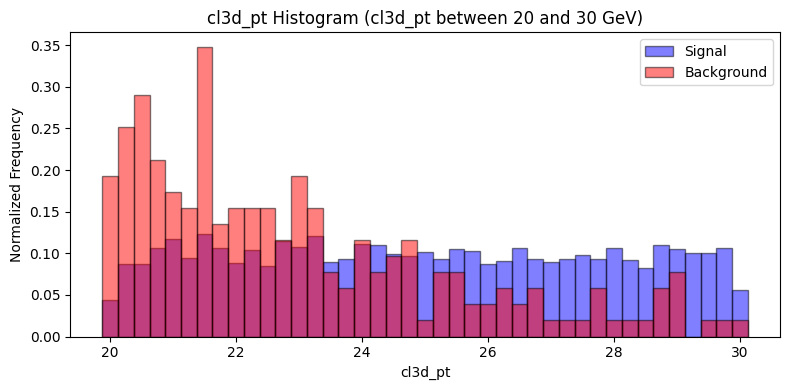

Saved: cl3d_energy_histogram_log_cl3d_pt_20_30.png


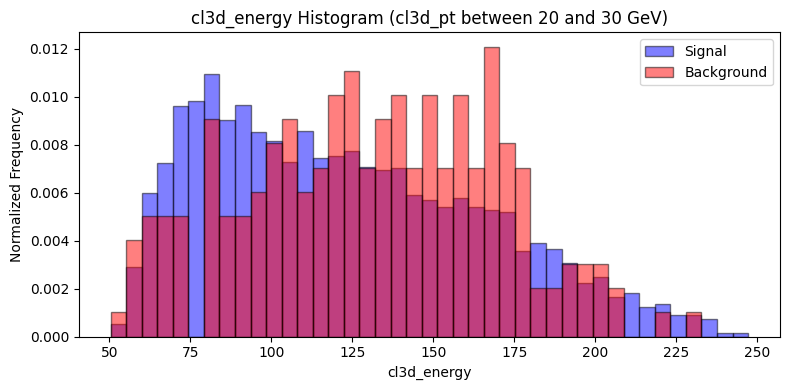

Saved: cl3d_eta_histogram_log_cl3d_pt_20_30.png


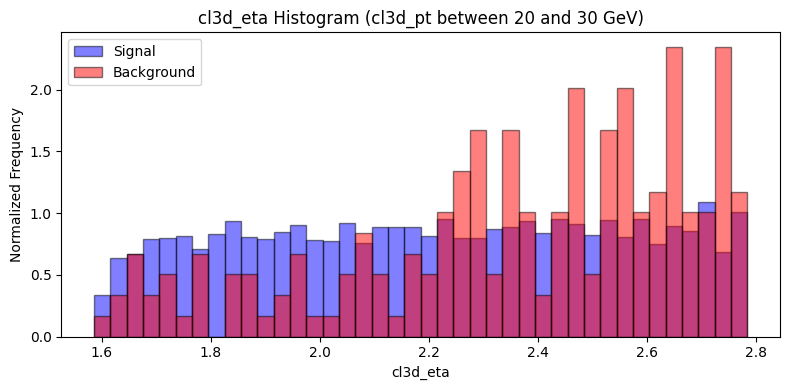

Saved: cl3d_phi_histogram_log_cl3d_pt_20_30.png


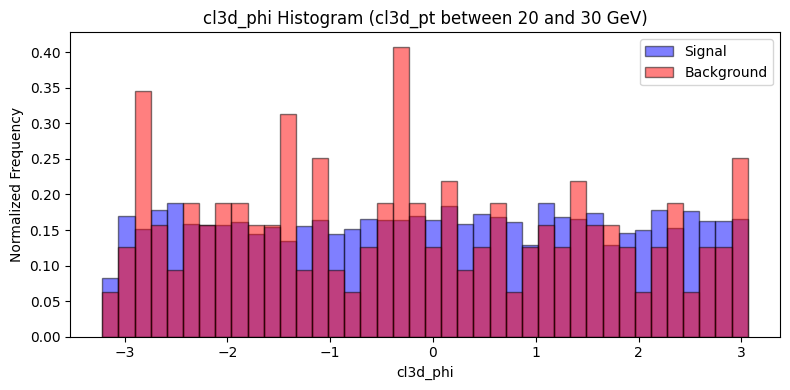

Saved: cl3d_showerlength_histogram_log_cl3d_pt_20_30.png


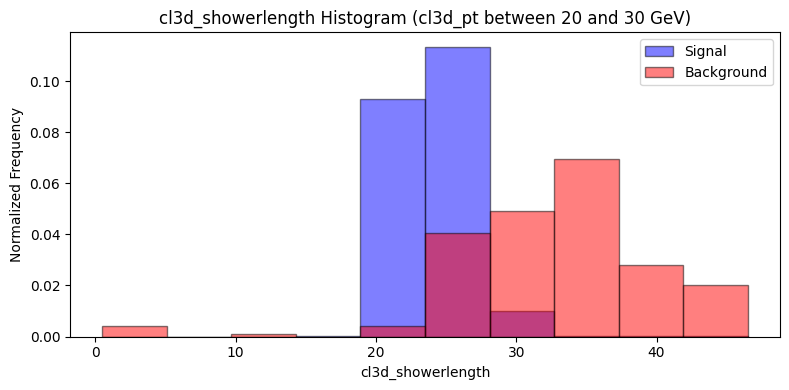

Saved: cl3d_coreshowerlength_histogram_log_cl3d_pt_20_30.png


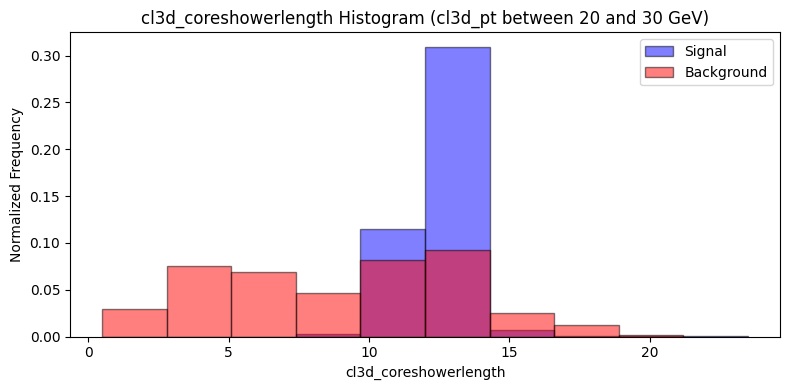

Saved: cl3d_firstlayer_histogram_log_cl3d_pt_20_30.png


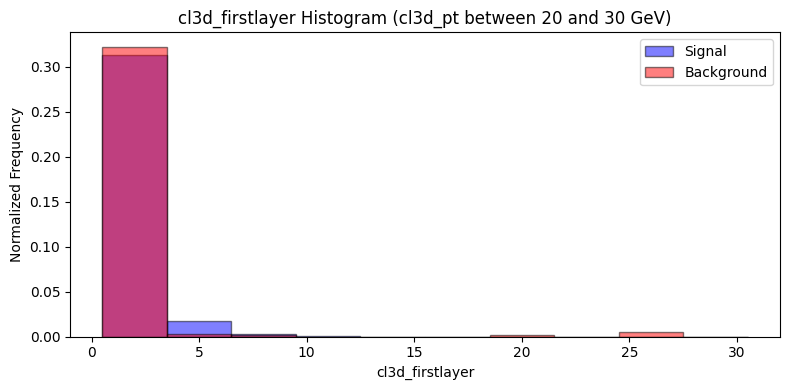

Saved: cl3d_maxlayer_histogram_log_cl3d_pt_20_30.png


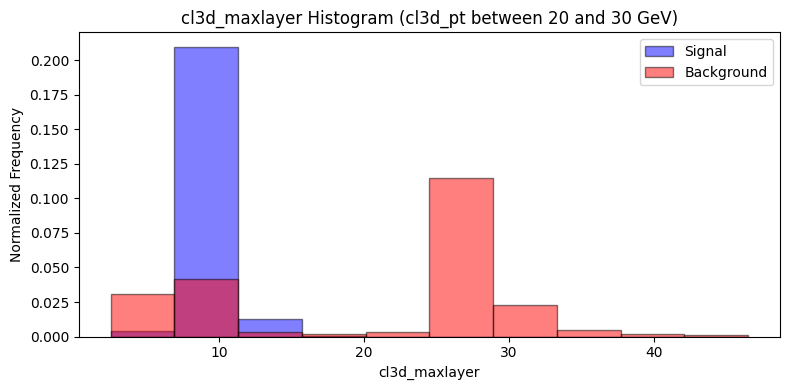

Saved: cl3d_seetot_histogram_log_cl3d_pt_20_30.png


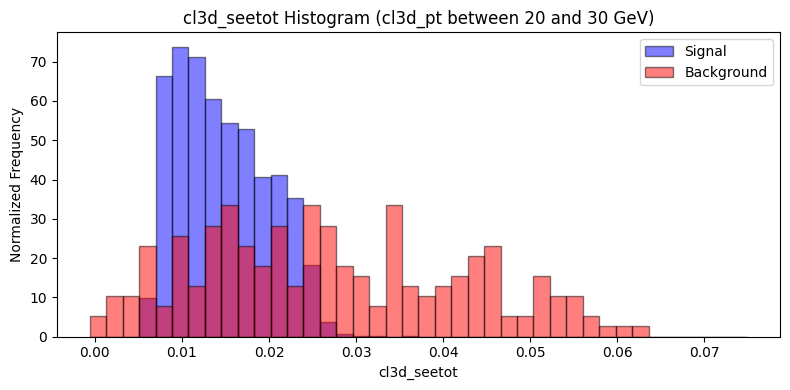

Saved: cl3d_seemax_histogram_log_cl3d_pt_20_30.png


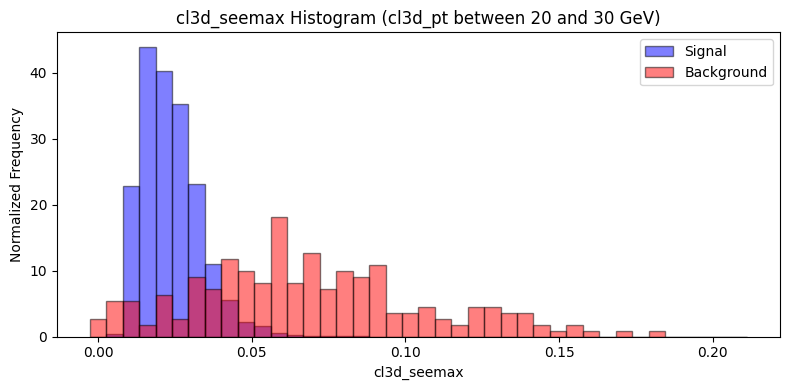

Saved: cl3d_spptot_histogram_log_cl3d_pt_20_30.png


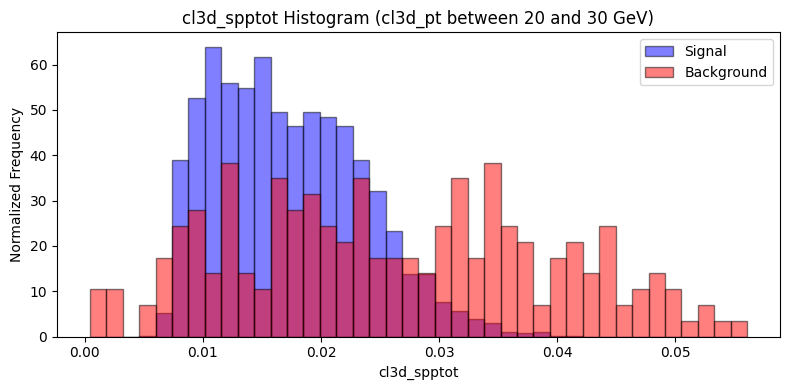

Saved: cl3d_sppmax_histogram_log_cl3d_pt_20_30.png


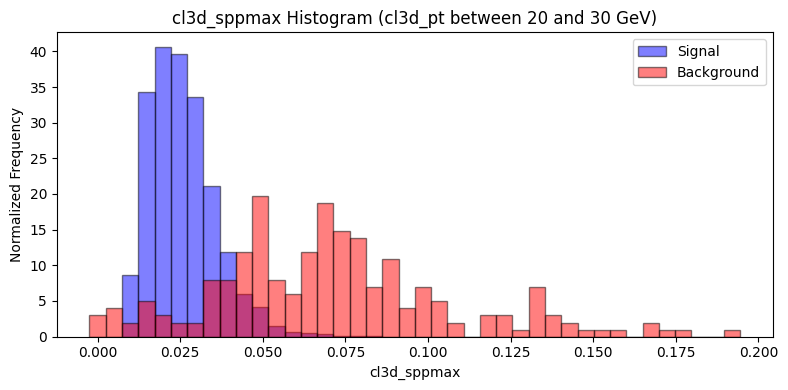

Saved: cl3d_szz_histogram_log_cl3d_pt_20_30.png


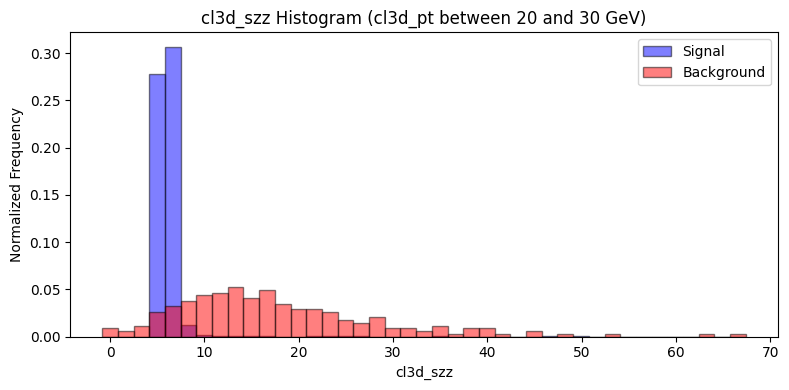

Saved: cl3d_srrtot_histogram_log_cl3d_pt_20_30.png


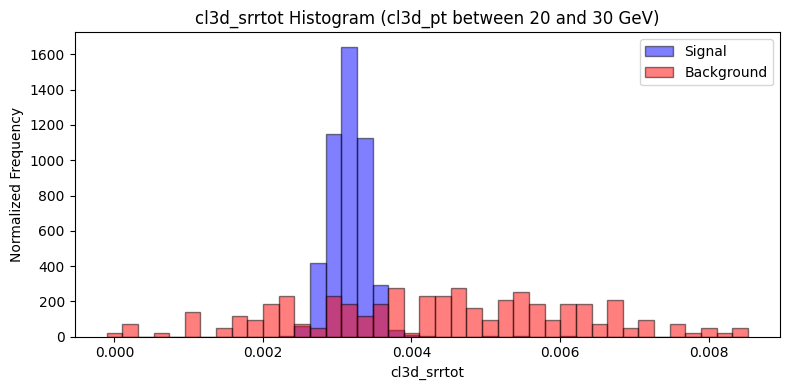

Saved: cl3d_srrmax_histogram_log_cl3d_pt_20_30.png


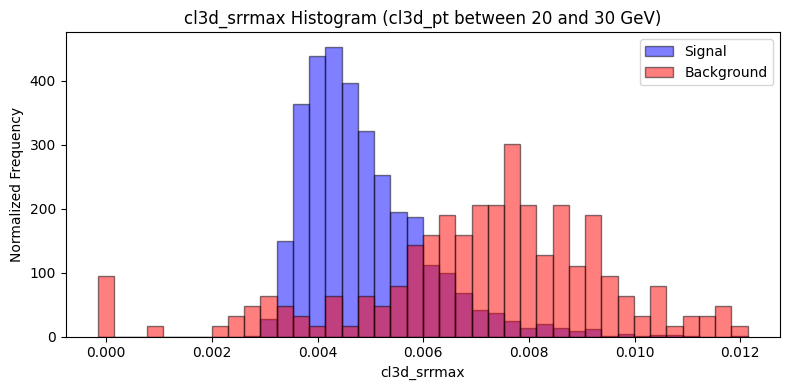

Saved: cl3d_srrmean_histogram_log_cl3d_pt_20_30.png


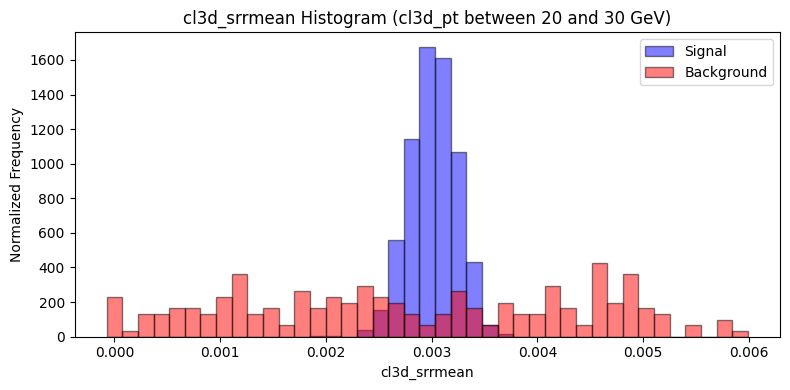

Saved: cl3d_varrr_histogram_log_cl3d_pt_20_30.png


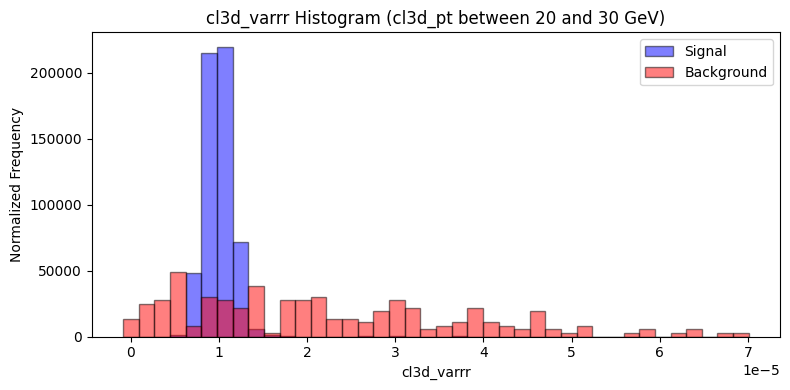

Saved: cl3d_varzz_histogram_log_cl3d_pt_20_30.png


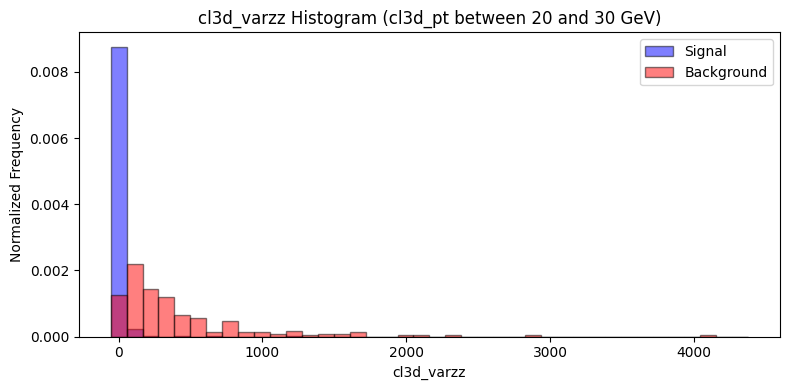

Saved: cl3d_varee_histogram_log_cl3d_pt_20_30.png


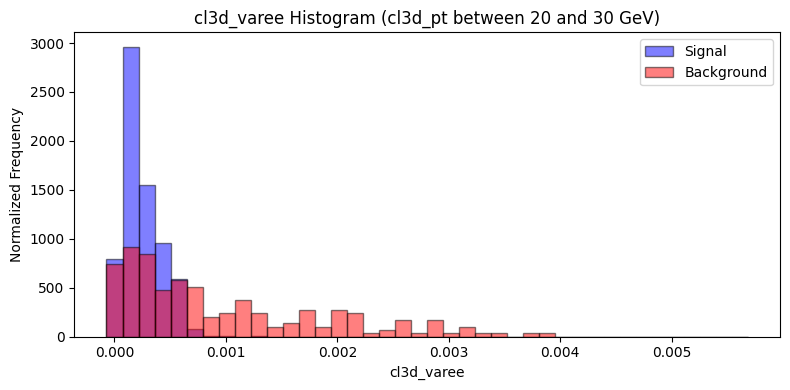

Saved: cl3d_varpp_histogram_log_cl3d_pt_20_30.png


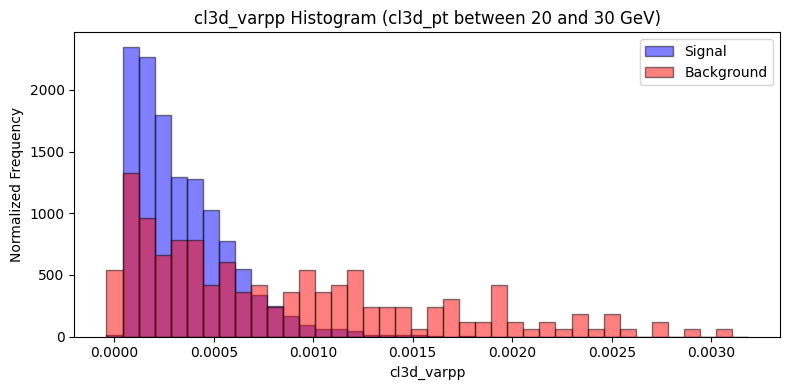

Saved: cl3d_emaxe_histogram_log_cl3d_pt_20_30.png


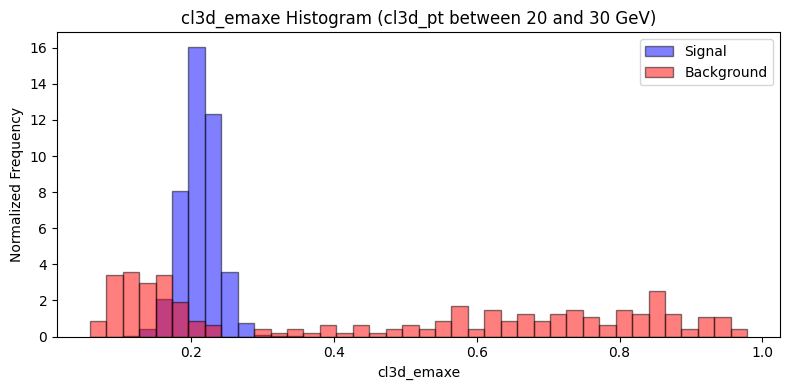

Saved: cl3d_hoe_histogram_log_cl3d_pt_20_30.png


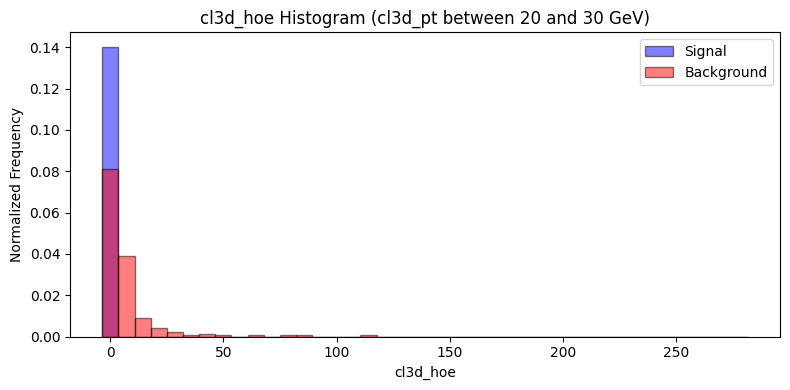

Saved: cl3d_meanz_histogram_log_cl3d_pt_20_30.png


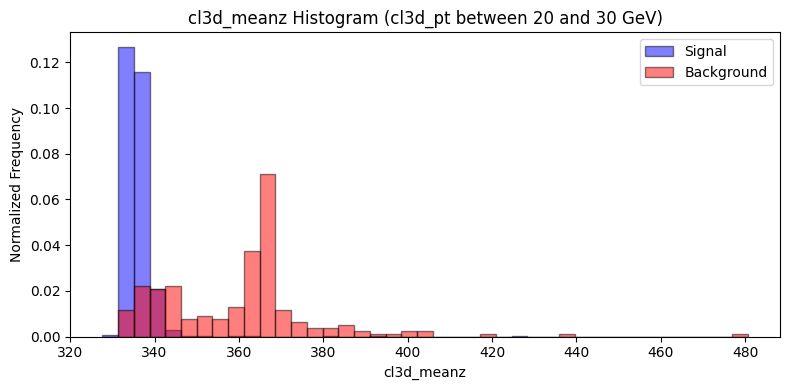

Saved: cl3d_layer10_histogram_log_cl3d_pt_20_30.png


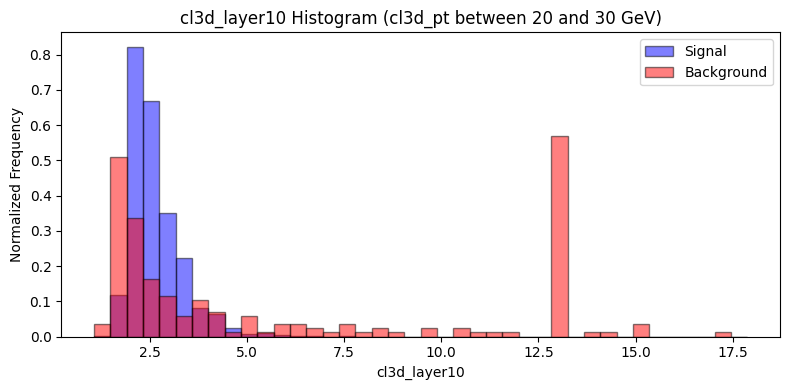

Saved: cl3d_layer50_histogram_log_cl3d_pt_20_30.png


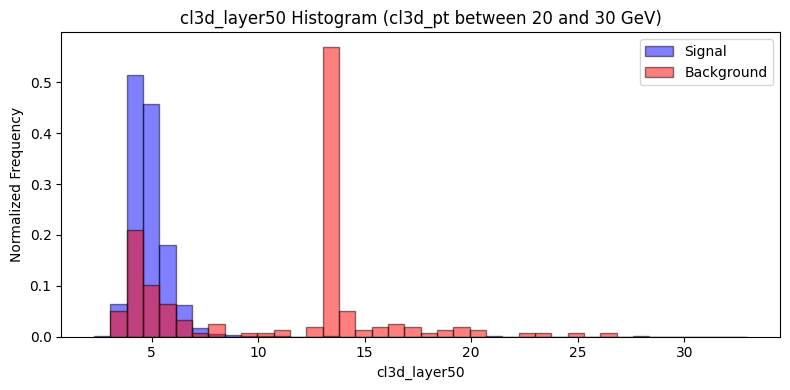

Saved: cl3d_layer90_histogram_log_cl3d_pt_20_30.png


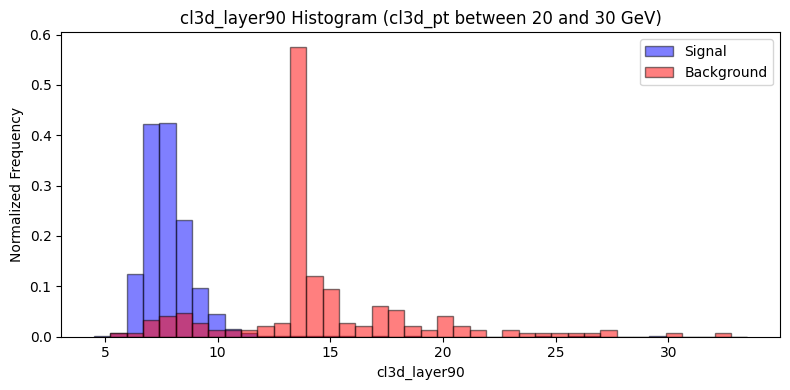

Saved: cl3d_first1layers_histogram_log_cl3d_pt_20_30.png


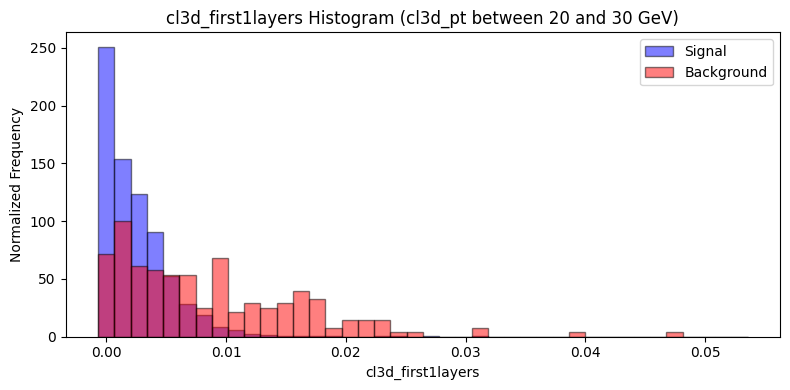

Saved: cl3d_first3layers_histogram_log_cl3d_pt_20_30.png


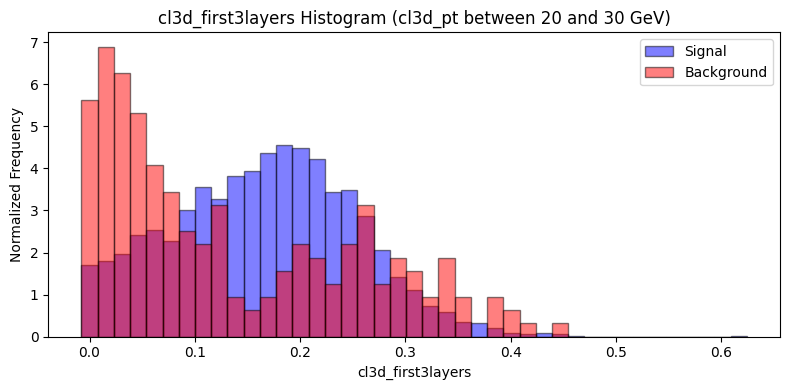

Saved: cl3d_first5layers_histogram_log_cl3d_pt_20_30.png


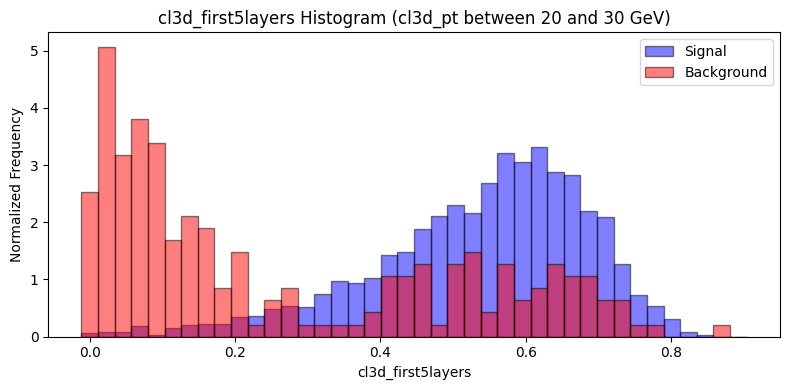

Saved: cl3d_firstHcal1layers_histogram_log_cl3d_pt_20_30.png


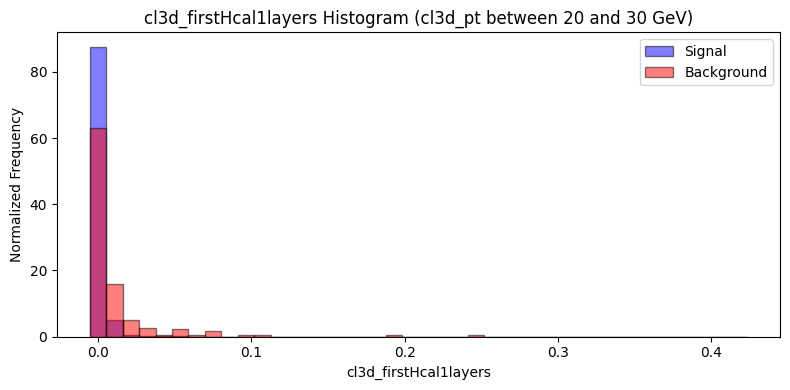

Saved: cl3d_firstHcal3layers_histogram_log_cl3d_pt_20_30.png


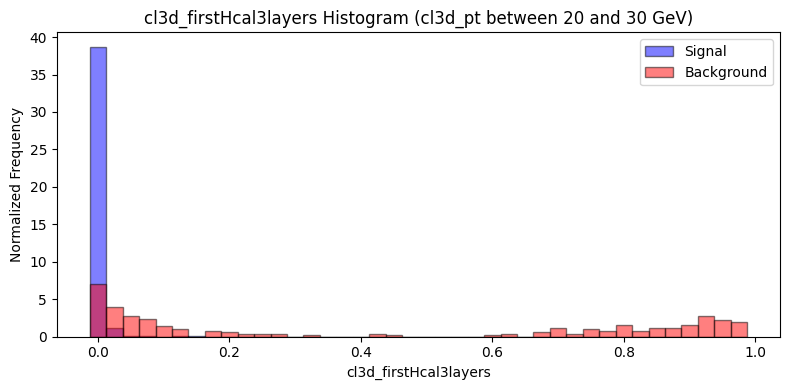

Saved: cl3d_firstHcal5layers_histogram_log_cl3d_pt_20_30.png


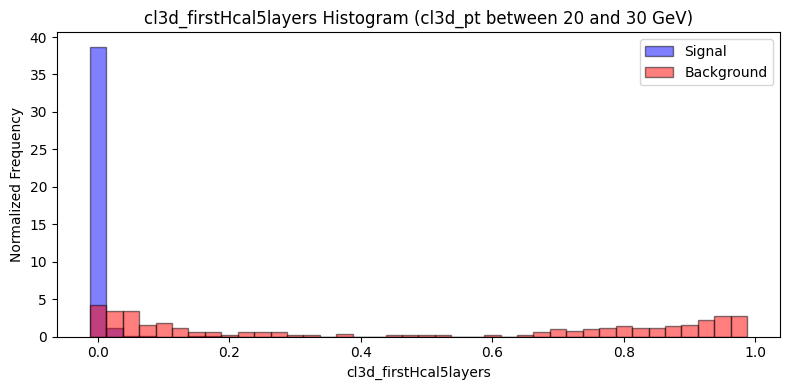

Saved: cl3d_last1layers_histogram_log_cl3d_pt_20_30.png


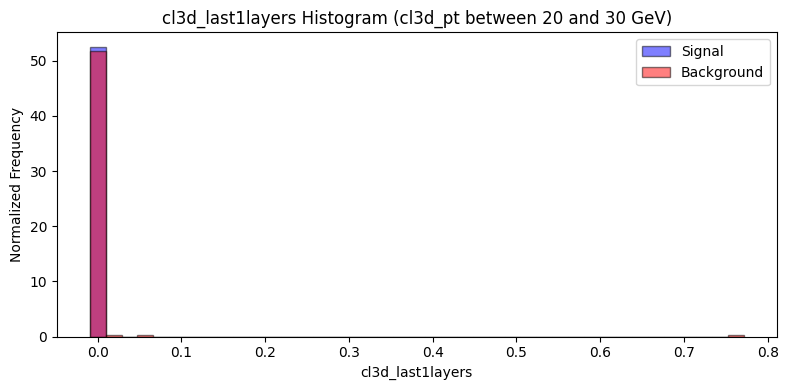

Saved: cl3d_last3layers_histogram_log_cl3d_pt_20_30.png


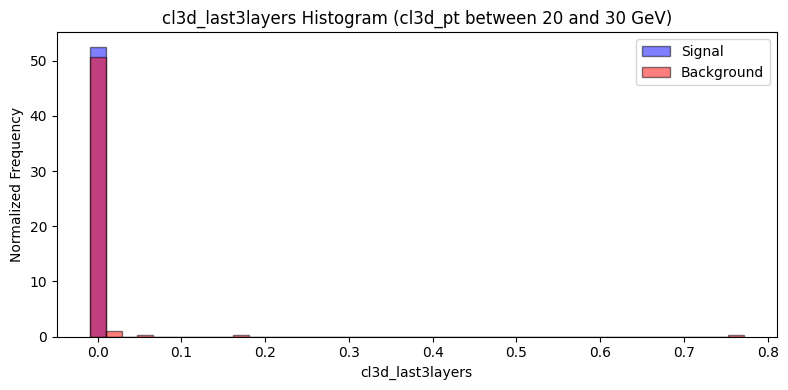

Saved: cl3d_last5layers_histogram_log_cl3d_pt_20_30.png


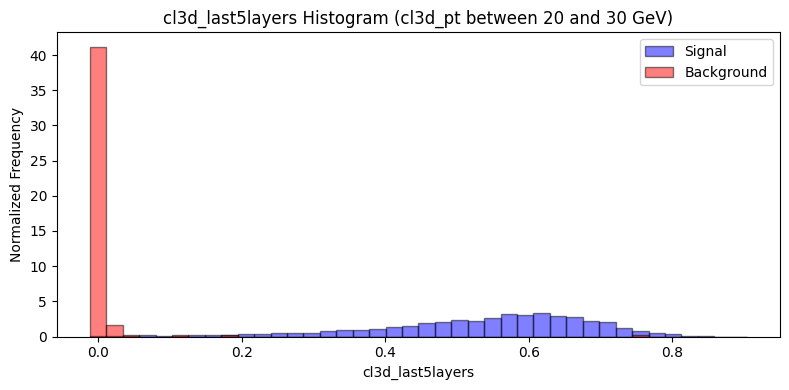

In [50]:
# Call the function with your filtered DataFrame and variables
plot_histograms(df_signal_final_filtered, bg_df_filtered, variables_to_plot, cl3d_pt_range=(20, 30))

In [13]:
# Get the common columns between signal and background DataFrames
common_columns = df_signal_final_filtered.columns.intersection(bg_df_filtered.columns)

# Keep only the common columns in both DataFrames
df_signal_filtered_final = df_signal_final_filtered[common_columns]
df_bg_filtered_final = bg_df_filtered[common_columns]

# Display the columns to verify
print("Signal DataFrame columns after filtering:", df_signal_filtered_final.columns)
print("Background DataFrame columns after filtering:", df_bg_filtered_final.columns)

Signal DataFrame columns after filtering: Index(['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'genpart_exphi',
       'genpart_exeta', 'cl3d_n', 'cl3d_id', 'cl3d_pt', 'cl3d_energy',
       'cl3d_eta', 'cl3d_phi', 'cl3d_clusters_n', 'cl3d_clusters_id',
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_varrr', 'cl3d_varzz', 'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe',
       'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_first1layers', 'cl3d_first3layers',
       'cl3d_first5layers', 'cl3d_firstHcal1layers', 'cl3d_firstHcal3layers',
       'cl3d_firstHcal5layers', 'cl3d_last1layers', 'cl3d_last3layers',
       'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers',
       'cl3d_emax5layers', 'cl3d_eot', 'cl3d_ebm0', 'cl3d_ebm1', 'cl3d_hbm',
       'cl3d_ntc67', 

In [14]:
# Add labels to signal (1) and background (0) DataFrames
df_signal_filtered_final['label'] = 1
df_bg_filtered_final['label'] = 0

# Select only the relevant cl3d variables and the label for training
cl3d_variables = [col for col in df_signal_filtered_final.columns if col.startswith('cl3d')]

# Merge signal and background datasets
df_combined = pd.concat([df_signal_filtered_final[cl3d_variables + ['label']],
                         df_bg_filtered_final[cl3d_variables + ['label']]],
                         ignore_index=True)

# Separate features and target
X = df_combined[cl3d_variables]
y = df_combined['label']

/tmp/ipykernel_124438/2757330137.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_filtered_final['label'] = 1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# Define the XGBoost model
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)

# Train the model
model.fit(X_train, y_train)

/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [17]:
# Predictions and performance metrics
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 1.00
ROC AUC: 1.00


In [18]:
# Define pT bins
pt_bins = [5, 10, 20, 50, 100, 200]  # Example bins
df_combined['pt_bin'] = pd.cut(df_combined['cl3d_pt'], bins=pt_bins, labels=False)

columns_for_training = [
    'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer',
    'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot', 'cl3d_sppmax', 'cl3d_szz',
    'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_varrr', 'cl3d_varzz',
    'cl3d_varee', 'cl3d_varpp', 'cl3d_emaxe', 'cl3d_meanz', 
    'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_first1layers',
    'cl3d_first3layers', 'cl3d_first5layers', 'cl3d_firstHcal1layers',
    'cl3d_firstHcal3layers', 'cl3d_firstHcal5layers', 'cl3d_last1layers',
    'cl3d_last3layers', 'cl3d_last5layers', 'cl3d_emax1layers', 'cl3d_emax3layers'
]

# Filter data for training
filtered_data = df_combined[columns_for_training + ['label', 'pt_bin']]

Training for pT bin: 5 - 10


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 5_importance_score.png


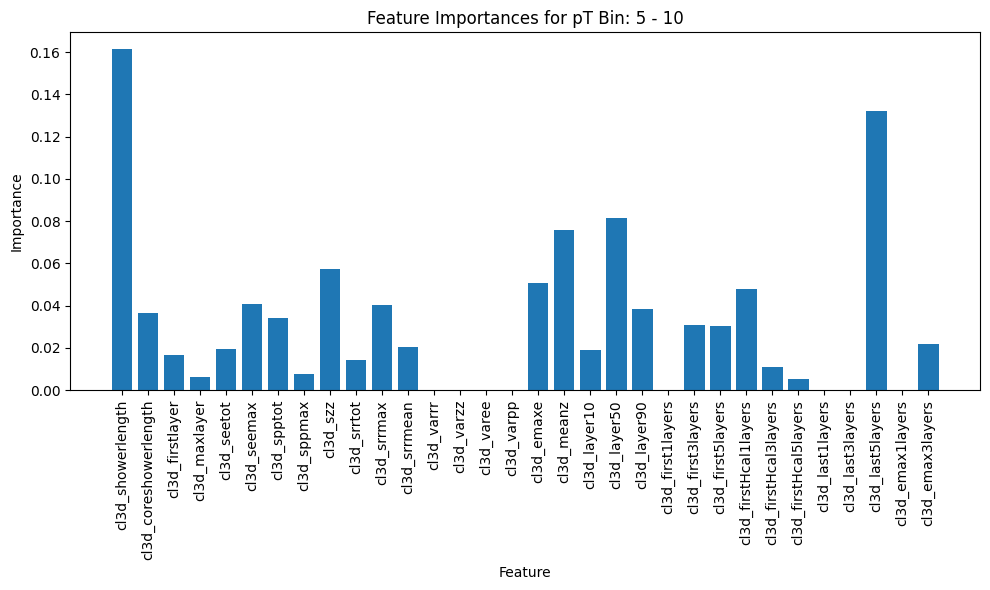

Training for pT bin: 10 - 20


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 10_importance_score.png


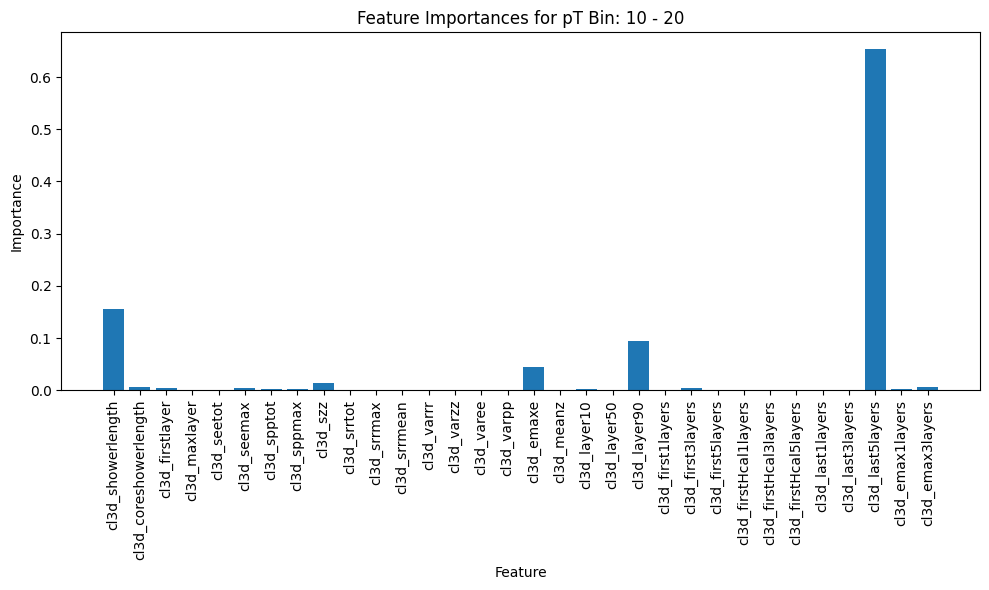

Training for pT bin: 20 - 50


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 20_importance_score.png


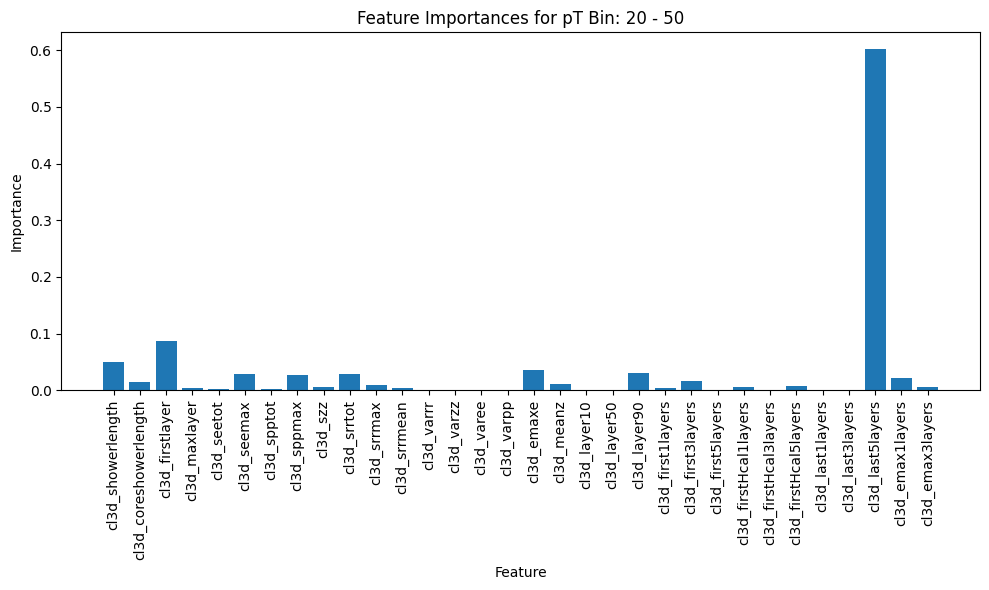

Training for pT bin: 50 - 100


/cvmfs/cms.cern.ch/slc7_amd64_gcc12/external/py3-xgboost/1.7.5-788de805c13027be61faccd00ffc7e59/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Saved: 50_importance_score.png


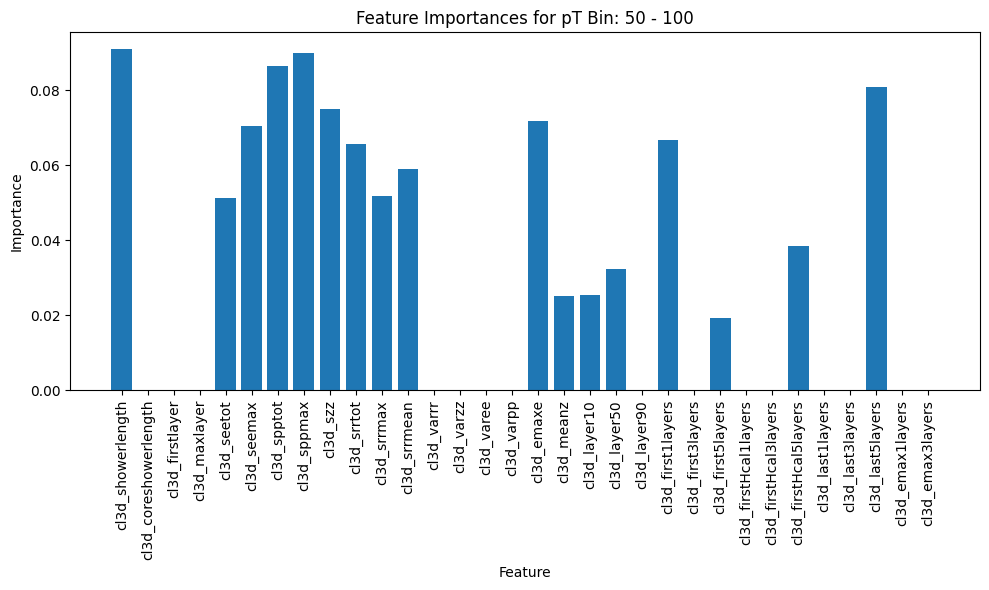

Training for pT bin: 100 - 200
Skipping bin 100 - 200 due to insufficient class diversity.


In [19]:
feature_importance_by_bin = {}

for pt_bin in range(len(pt_bins) - 1):  # Loop through bins
    print(f"Training for pT bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    
    # Filter data for the current bin
    bin_data = filtered_data[filtered_data['pt_bin'] == pt_bin]
    X = bin_data[columns_for_training]
    y = bin_data['label']
    
    # Check class balance
    class_counts = y.value_counts()
    if len(class_counts) < 2:  # Less than two classes present
        print(f"Skipping bin {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]} due to insufficient class diversity.")
        continue
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train XGBoost model
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1
    )
    model.fit(X_train, y_train)
    
    # Save feature importances
    feature_importances = model.feature_importances_
    feature_importance_by_bin[pt_bin] = feature_importances
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(columns_for_training, feature_importances)
    plt.xticks(rotation=90)
    plt.title(f"Feature Importances for pT Bin: {pt_bins[pt_bin]} - {pt_bins[pt_bin + 1]}")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    filename = f"{pt_bins[pt_bin]}_importance_score.png"
    plt.savefig(filename, dpi=300)
    print(f"Saved: {filename}")    
    plt.show()

In [21]:
bg_df_filtered = bg_df_filtered[bg_df_filtered['cl3d_pt'] > 20]

In [22]:
bg_df_filtered

event  gen_n   gen_eta   gen_phi    gen_pt   
entry subentry subsubentry                                                
366   189      0               369    357  2.235956  1.837012  1.431968  \
               1               369    357  2.235956  1.837012  1.431968   
68    179      0              5816   1643  2.040692 -1.899767  2.524277   
               1              5816   1643  2.040692 -1.899767  2.524277   
423   160      0              6344    612  1.935576  0.628054  4.546344   
...                            ...    ...       ...       ...       ...   
209   211      1            156929    923  2.399943 -1.741889  0.667195   
      284      0            156929    923  2.069482  1.824589  2.009918   
               1            156929    923  2.069482  1.824589  2.009918   
595   211      0            157282   2636  2.158431  2.676478  3.080648   
               1            157282   2636  2.158431  2.676478  3.080648   

                            genpart_exphi  genpart_exeta  cl3d_n     cl3d_id   
entry subentry subsubentry                                                     
366   189      0                -1.745044      -1.120163     274  2992513586  \
               1                -1.745044      -1.120163     274  2992513586   
68    179      0                 2.021710      -1.094230     237  3031872083   
               1                 2.021710      -1.094230     237  3031872083   
423   160      0                 1.298342      -4.171930     238  2988192288   
...                                   ...            ...     ...         ...   
209   211      1                 2.829054       2.758655     290  2988196678   
      284      0                -2.465207       0.866757     290  3037095523   
               1                -2.465207       0.866757     290  3037095523   
595   211      0                -1.278087       0.549843     242  2991891216   
               1                -1.278087       0.549843     242  2991891216   

                              cl3d_pt  ...  cl3d_eot  cl3d_ebm0  cl3d_ebm1   
entry subentry subsubentry             ...                                   
366   189      0            20.155027  ...  0.884482       8191       3096  \
               1            20.155027  ...  0.884482       8191       3096   
68    179      0            21.319664  ...  0.333680       8166       3072   
               1            21.319664  ...  0.333680       8166       3072   
423   160      0            27.937033  ...  0.879023       8191       4032   
...                               ...  ...       ...        ...        ...   
209   211      1            28.923901  ...  1.000000       8188       4064   
      284      0            20.319881  ...  0.005918       1088          0   
               1            20.319881  ...  0.005918       1088          0   
595   211      0            21.109205  ...  0.436408       8190        384   
               1            21.109205  ...  0.436408       8190        384   

                            cl3d_hbm  cl3d_ntc67  cl3d_ntc90  cl3d_bdteg   
entry subentry subsubentry                                                 
366   189      0             3672064   37.693329   71.331642   -0.998875  \
               1             3672064   37.693329   71.331642   -0.998875   
68    179      0              344833    4.927095   28.380890   -0.998929   
               1              344833    4.927095   28.380890   -0.998929   
423   160      0             4050944   30.518538   76.151062   -0.992707   
...                              ...         ...         ...         ...   
209   211      1                   0   21.464155   64.158897   -0.939645   
      284      0             1048576    0.673988    0.905358   -0.998945   
               1             1048576    0.673988    0.905358   -0.998945   
595   211      0             2080768   21.442961   46.415447   -0.996330   
               1             2080768   21.442961   46.415447   -0.996330   

        